# Unsupervised

# Pre-processing data

In [242]:
import pandas as pd 

cd = pd.read_csv('Dataset/dataset_2.csv')

# Vérifier s'il y a des genres combinés
combined_genres = cd['track_genre'].str.contains(',')

# Séparer les genres combinés en plusieurs lignes
cd = cd.assign(track_genre=cd['track_genre'].str.split(',')).explode('track_genre')

# Supprimer les espaces blancs autour des genres après la séparation
cd['track_genre'] = cd['track_genre'].str.strip()

cd.reset_index(drop=True, inplace=True)

cd['genre'] = cd['track_genre']

cd = cd.dropna()  # Drop rows with missing values

df = cd.drop(columns=['artists', 'track_name', 'track_genre','time_signature'])
# 'genre_lenght

# Hierarchical 

In the previous section, we attempted to use supervised learning to predict the track genre, but the results were not satisfactory. To improve our model's performance, we will now apply unsupervised learning methods, such as hierarchical clustering and the K-means algorithm. The goal is to group tracks by genre into clusters, which can reveal underlying similarities between them. This approach may enhance our model's ability to predict genres more accurately or, at the very least, enable it to work effectively with genre groups that share similar characteristics.

## Cluster

In [243]:
df_linkage = df.copy()
df_linkage

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,acoustic
1,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,j-pop
2,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,singer-songwriter
3,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,songwriter
4,55,149610,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100204,21,384999,0.172,0.235,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,world-music
100205,22,385000,0.174,0.117,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,world-music
100206,22,271466,0.629,0.329,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,world-music
100207,41,283893,0.587,0.506,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,world-music


In [244]:
import pandas as pd

custom_aggregation = {
    'popularity': 'median',
    'duration_ms': 'median',
    'danceability': 'mean',
    'energy': 'mean',
    'key': lambda x: x.mode()[0],  # Mode for categorical data
    'loudness': 'median',
    'speechiness': lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR for spread
    'acousticness': 'median',
    'instrumentalness': 'median',
    'liveness': lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR for spread
    'valence': 'mean',
    'tempo': 'std'  # Standard Deviation for variability
}

# Group by 'genre' and apply custom aggregation
genre_aggregated = df_linkage.groupby('genre').agg(custom_aggregation)



In [245]:
from sklearn.preprocessing import StandardScaler

# Standardize the aggregated data
scaler = StandardScaler()
genre_scaled = scaler.fit_transform(genre_aggregated)

# Convert back to DataFrame for easier interpretation
genre_scaled_df = pd.DataFrame(genre_scaled, index=genre_aggregated.index, columns=genre_aggregated.columns)
print(genre_scaled_df.head())


             popularity  duration_ms  danceability    energy       key  \
genre                                                                    
acoustic       0.758133    -0.098784     -0.146762 -1.199176 -0.910651   
afrobeat      -0.827686     0.308498      0.911523  0.357374  1.074866   
alt-rock       0.697140     0.286343     -0.255585  0.598008  1.642157   
alternative   -1.803574    -0.016329     -0.036001  0.431675  1.642157   
ambient        0.941112    -0.002323     -1.791637 -2.374559 -0.910651   

             loudness  speechiness  acousticness  instrumentalness  liveness  \
genre                                                                          
acoustic    -0.339165    -0.850296      1.402430         -0.438020 -1.037762   
afrobeat     0.148534     0.011765     -0.371132         -0.406423 -0.520535   
alt-rock     0.545044    -0.541353     -0.865563         -0.437758  0.156272   
alternative  0.598541    -0.316093     -0.827927         -0.437965 -0.016450   
a

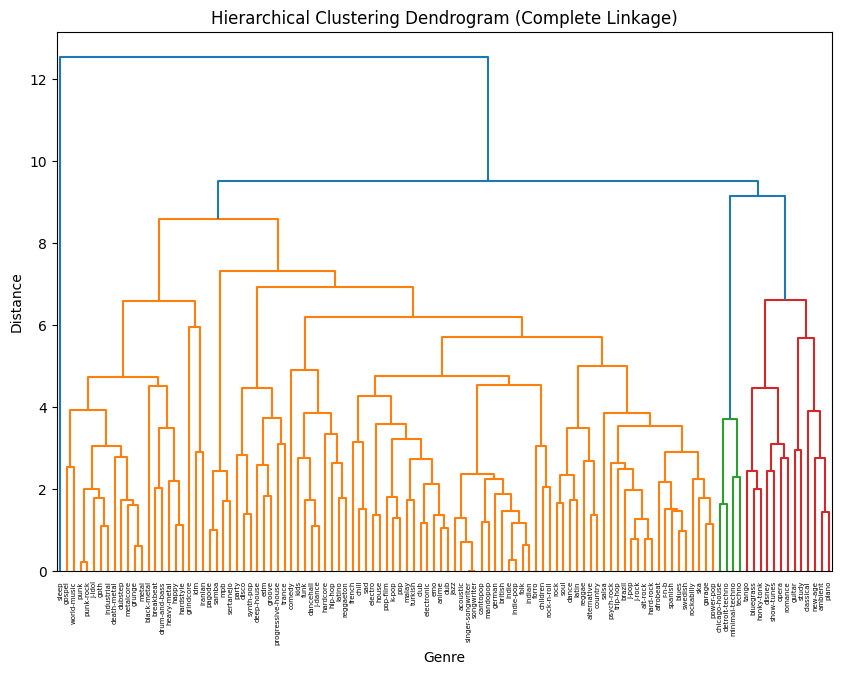

In [246]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Apply complete linkage hierarchical clustering
Z = linkage(genre_scaled_df, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=genre_scaled_df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Genre')
plt.ylabel('Distance')
plt.show()


In [247]:
from scipy.cluster.hierarchy import fcluster

# Specify the number of clusters you want
num_clusters = 12  # Change this value to your desired number of clusters

# Form flat clusters by specifying the number of clusters
genre_clusters = fcluster(Z, t=num_clusters, criterion='maxclust')

# Add the cluster labels to the genre DataFrame
genre_clustered_df = genre_aggregated.copy()
genre_clustered_df['cluster_hierarchical'] = genre_clusters

# Display the resulting clusters sorted by cluster labels
#genre_clustered_df[['cluster_hierarchical']].sort_values(by='cluster_hierarchical')

In [248]:
# Group by cluster labels and list the genres in each cluster, selecting columns after groupby
genres_per_cluster = genre_clustered_df.groupby('cluster_hierarchical').apply(lambda x: list(x.index.get_level_values(0)))

# Convert to DataFrame for easier interpretation
genres_per_cluster_df = pd.DataFrame(genres_per_cluster, columns=['genre'])

# Display the genres in each cluster
genres_per_cluster

/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/3330988936.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genres_per_cluster = genre_clustered_df.groupby('cluster_hierarchical').apply(lambda x: list(x.index.get_level_values(0)))


cluster_hierarchical
1     [black-metal, breakbeat, death-metal, drum-and...
2                                        [idm, iranian]
3                                           [grindcore]
4                       [mpb, pagode, samba, sertanejo]
5     [deep-house, disco, edm, groove, party, progre...
6     [comedy, dancehall, funk, hardcore, hip-hop, j...
7     [acoustic, anime, british, cantopop, children,...
8     [afrobeat, alt-rock, alternative, blues, brazi...
9     [chicago-house, detroit-techno, minimal-techno...
10    [bluegrass, disney, honky-tonk, opera, romance...
11    [ambient, classical, guitar, new-age, piano, s...
12                                              [sleep]
dtype: object

In [249]:
import pandas as pd

# Supposons que genre_clustered_df est déjà votre DataFrame avec les labels de cluster

# Grouper par labels de cluster et obtenir une liste des genres pour chaque cluster
genres_per_cluster = genre_clustered_df.groupby('cluster_hierarchical').apply(lambda x: list(x.index.get_level_values(0)))

# Convertir en DataFrame pour une meilleure présentation
genres_per_cluster_df = pd.DataFrame(genres_per_cluster, columns=['genres'])
genres_per_cluster_df.index.name = 'cluster'

# Exporter le DataFrame en CSV
genres_per_cluster_df.to_csv('genres_per_cluster.csv')

# Afficher un message de confirmation
print("Les genres par cluster ont été exportés dans 'genres_per_cluster.csv'.")


Les genres par cluster ont été exportés dans 'genres_per_cluster.csv'.


/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/470077256.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genres_per_cluster = genre_clustered_df.groupby('cluster_hierarchical').apply(lambda x: list(x.index.get_level_values(0)))


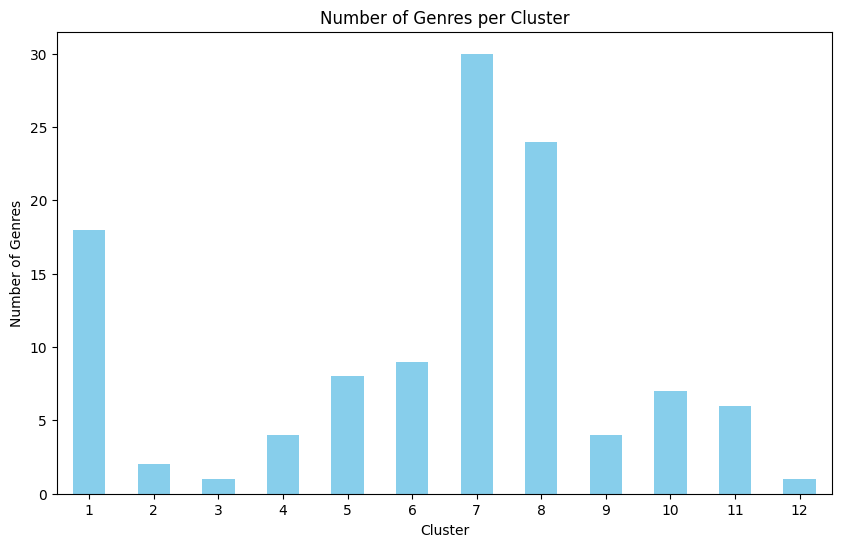

In [156]:
# First, create a mapping from the genre to the cluster label
genre_to_cluster = genre_clustered_df['cluster_hierarchical'].to_dict()

# Add the cluster_hierarchical column to df_linkage based on the genre
df_linkage['cluster_hierarchical'] = df_linkage['genre'].map(genre_to_cluster)

import matplotlib.pyplot as plt

# Count the number of genres in each cluster
genre_counts = genres_per_cluster_df['genre'].apply(len)

# Plotting
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Genres per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Genres')
plt.xticks(rotation=0)
plt.show()


After using many different linkage methods, it is always 

## Random Forrest 0.59

In [157]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define features (X) and labels (y)
X = df_linkage.drop(columns=['cluster_hierarchical', 'genre'])
y = df_linkage['cluster_hierarchical']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators = 100,random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print the classification report for detailed performance metrics
print(classification_report(y_test, y_pred))

# Feature importance (optional, to understand which features are most influential)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


Accuracy: 0.5885
              precision    recall  f1-score   support

           1       0.63      0.67      0.65      3462
           2       0.73      0.56      0.63       364
           3       0.94      0.86      0.90       197
           4       0.68      0.55      0.61       770
           5       0.53      0.37      0.44      1310
           6       0.58      0.46      0.51      1491
           7       0.55      0.66      0.60      5358
           8       0.46      0.45      0.46      3761
           9       0.72      0.72      0.72       760
          10       0.73      0.71      0.72      1322
          11       0.66      0.61      0.63      1065
          12       0.94      0.79      0.86       182

    accuracy                           0.59     20042
   macro avg       0.68      0.62      0.64     20042
weighted avg       0.59      0.59      0.59     20042

             Feature  Importance
0         popularity    0.123465
8       acousticness    0.111014
2       danceabil

### GridSearch - hyperparamaters tuning and cross-fold 


In [158]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with tuned model: {accuracy:.4f}')

# Print the classification report for the tuned model
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  17.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  17.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  17.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  17.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.1s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_s

## SVM, kNN, GBM 

In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Define features (X) and labels (y)
X = df_linkage.drop(columns=['cluster_hierarchical', 'genre'])
y = df_linkage['cluster_hierarchical']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the target labels for XGBoost
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialize models
models = {
    "Support Vector Machine": SVC(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    if model_name == "XGBoost":
        model.fit(X_train_scaled, y_train_adjusted)  # Use adjusted labels for XGBoost
        y_pred_adjusted = model.predict(X_test_scaled)
        y_pred = y_pred_adjusted + 1  # Adjust predictions back to original labels
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {model_name}: {accuracy:.4f}")
    #print(classification_report(y_test, y_pred))
    print("-" * 50)


Training Support Vector Machine...
Accuracy with Support Vector Machine: 0.5455
--------------------------------------------------
Training Gradient Boosting...
Accuracy with Gradient Boosting: 0.5654
--------------------------------------------------
Training k-Nearest Neighbors...
Accuracy with k-Nearest Neighbors: 0.5003
--------------------------------------------------
Training XGBoost...


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy with XGBoost: 0.5941
--------------------------------------------------


## XGBoost 0.7447

### Parameters

In [161]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Define features (X) and labels (y)
X = df_linkage.drop(columns=['cluster_hierarchical', 'genre'])
y = df_linkage['cluster_hierarchical']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the target labels for XGBoost
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Define the XGBoost model
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],      # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],   # Step size shrinkage
    'max_depth': [3, 5, 7],              # Maximum depth of trees
    'subsample': [0.8, 1.0]             # Subsample ratio of the training data
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the model with grid search
grid_search.fit(X_train_scaled, y_train_adjusted)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_accuracy:.4f}")

# Evaluate on the test set
y_pred_adjusted = grid_search.best_estimator_.predict(X_test_scaled)
y_pred = y_pred_adjusted + 1  # Adjust predictions back to original labels
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Parameters: {test_accuracy:.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.5955
Test Accuracy with Best Parameters: 0.6024


### Optimal

Final Accuracy on Test Data: 0.5977
              precision    recall  f1-score   support

           1       0.65      0.68      0.67      3462
           2       0.67      0.60      0.63       364
           3       0.93      0.89      0.91       197
           4       0.66      0.58      0.62       770
           5       0.52      0.41      0.46      1310
           6       0.61      0.46      0.53      1491
           7       0.56      0.67      0.61      5358
           8       0.48      0.45      0.46      3761
           9       0.74      0.70      0.72       760
          10       0.72      0.70      0.71      1322
          11       0.68      0.63      0.65      1065
          12       0.94      0.83      0.88       182

    accuracy                           0.60     20042
   macro avg       0.68      0.63      0.65     20042
weighted avg       0.60      0.60      0.60     20042



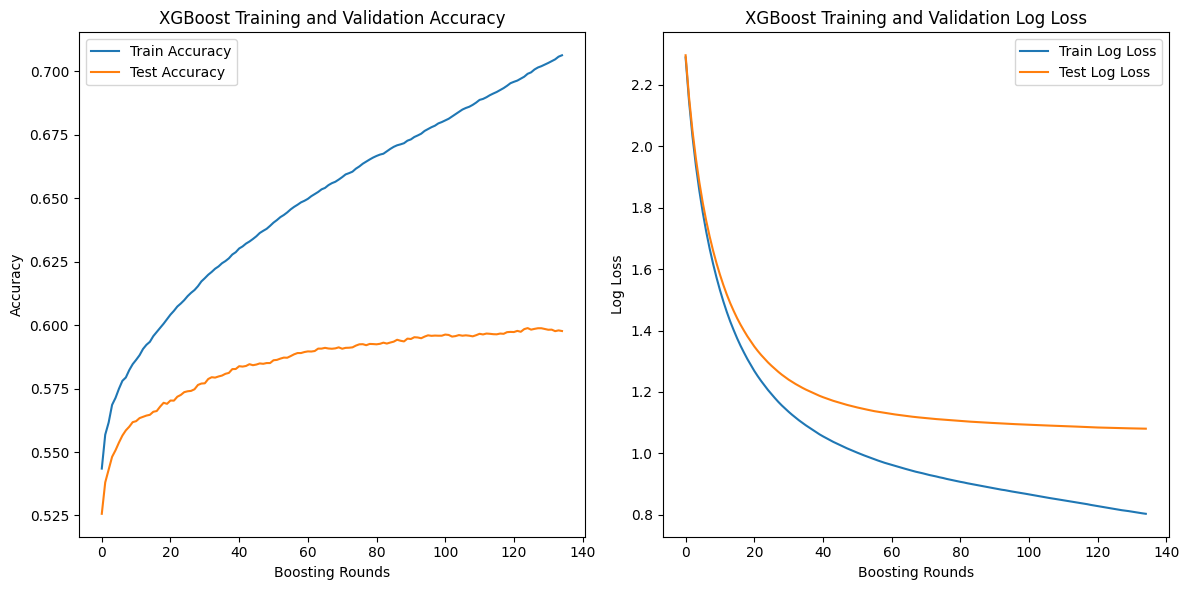

In [164]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

# Define features (X) and labels (y)
X = df_linkage.drop(columns=['cluster_hierarchical', 'genre'])
y = df_linkage['cluster_hierarchical']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the target labels for XGBoost (assuming the labels are starting from 1)
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert the datasets into DMatrix, which is the data structure that XGBoost uses
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_adjusted)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_adjusted)

# Define the parameters for XGBoost
params = {
    'objective': 'multi:softmax',
    'eval_metric': ['mlogloss', 'merror'],  # Include both log loss and error rate
    'num_class': len(y.unique()),  # Assuming the number of unique classes
    'learning_rate': 0.1,
    'max_depth': 7,
    'subsample': 0.8,
    'random_state': 42
}

# Number of boosting rounds
num_boost_round = 500

# Optionally, set up evaluation sets to track model performance
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}  # This dictionary will store the evaluation results

# Train the model with early stopping to prevent overfitting
bst = xgb.train(
    params, 
    dtrain, 
    num_boost_round, 
    evals=evals, 
    early_stopping_rounds=10, 
    evals_result=evals_result, 
    verbose_eval=False
)

# Make predictions on the test set
y_pred_adjusted = bst.predict(dtest)

# Adjust predictions back to original labels
y_pred = y_pred_adjusted + 1

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy on Test Data: {accuracy:.4f}")

# Optionally, print classification report
print(classification_report(y_test, y_pred))

# Extract metrics for plotting
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(epochs)

# Calculate accuracy from error
train_accuracy = [1 - x for x in evals_result['train']['merror']]
eval_accuracy = [1 - x for x in evals_result['eval']['merror']]

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_axis, train_accuracy, label='Train Accuracy')
plt.plot(x_axis, eval_accuracy, label='Test Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('XGBoost Training and Validation Accuracy')
plt.legend()

# Plot log loss
plt.subplot(1, 2, 2)
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train Log Loss')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Test Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Log Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Neural network 0.736

### Neural 1

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/50


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - accuracy: 0.4287 - loss: 1.6229 - val_accuracy: 0.5085 - val_loss: 1.3617
Epoch 2/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - accuracy: 0.5158 - loss: 1.3295 - val_accuracy: 0.5288 - val_loss: 1.2941
Epoch 3/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - accuracy: 0.5305 - loss: 1.2845 - val_accuracy: 0.5423 - val_loss: 1.2673
Epoch 4/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - accuracy: 0.5356 - loss: 1.2602 - val_accuracy: 0.5387 - val_loss: 1.2592
Epoch 5/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 351us/step - accuracy: 0.5409 - loss: 1.2446 - val_accuracy: 0.5469 - val_loss: 1.2381
Epoch 6/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 346us/step - accuracy: 0.5519 - loss: 1.2208 - val_accuracy: 0.5437 - val_loss: 1.2340
Epoch 7/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - accuracy: 0.5525 - loss: 1.2183 - val_accuracy: 0.5546 - val_loss: 1.2166
Epoch 8/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - accuracy: 0.5533 - loss: 1.21

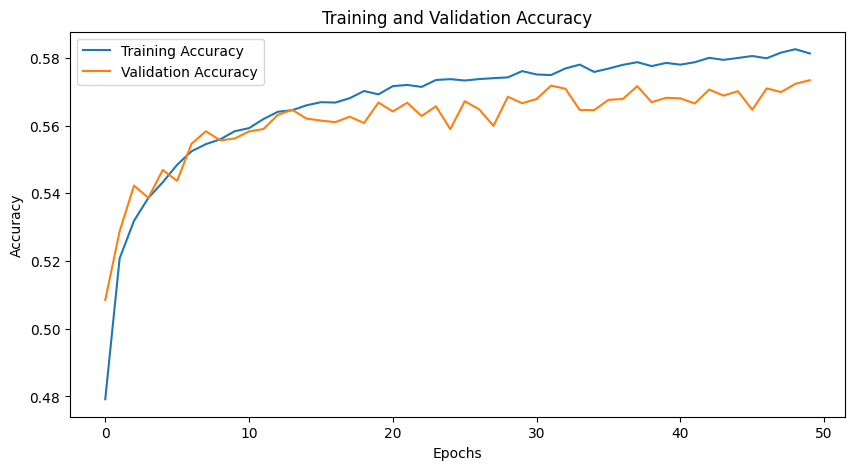

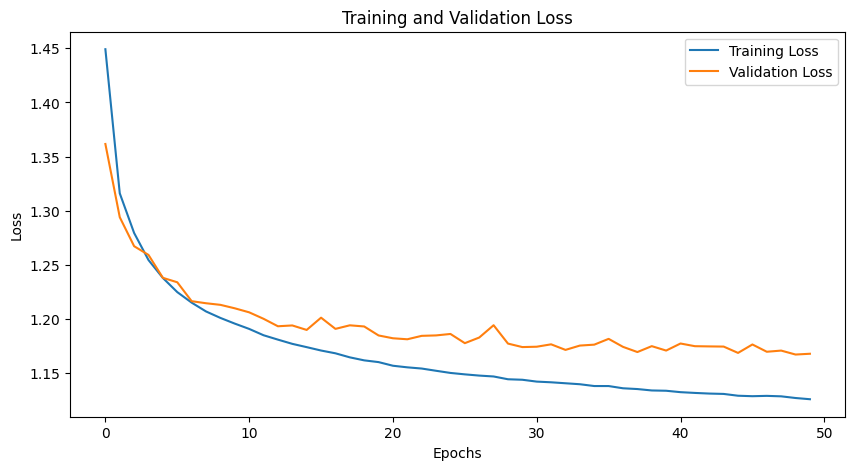

In [165]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the data (assuming it's already loaded in the DataFrame)
df = df_linkage.copy()

# Drop 'key' and 'genre'
df = df.drop(['genre'], axis=1)

# Split the data into features (X) and target (y)
X = df.drop('cluster_hierarchical', axis=1)
y = df['cluster_hierarchical']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target variable
y_encoded = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predictions (optional)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Neural 2

Epoch 1/50


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step - accuracy: 0.3544 - loss: 1.8146 - val_accuracy: 0.4845 - val_loss: 1.4280
Epoch 2/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.5076 - loss: 1.3735 - val_accuracy: 0.5289 - val_loss: 1.3233
Epoch 3/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - accuracy: 0.5309 - loss: 1.3053 - val_accuracy: 0.5371 - val_loss: 1.2921
Epoch 4/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.5399 - loss: 1.2684 - val_accuracy: 0.5427 - val_loss: 1.2624
Epoch 5/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.5490 - loss: 1.2378 - val_accuracy: 0.5513 - val_loss: 1.2394
Epoch 6/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 441us/step - accuracy: 0.5585 - loss: 1.2125 - val_accuracy: 0.5601 - val_loss: 1.2169
Epoch 7/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - accuracy: 0.5631 - loss: 1.2020 - val_accuracy: 0.5606 - val_loss: 1.2140
Epoch 8/50
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.5716 - loss: 1.17

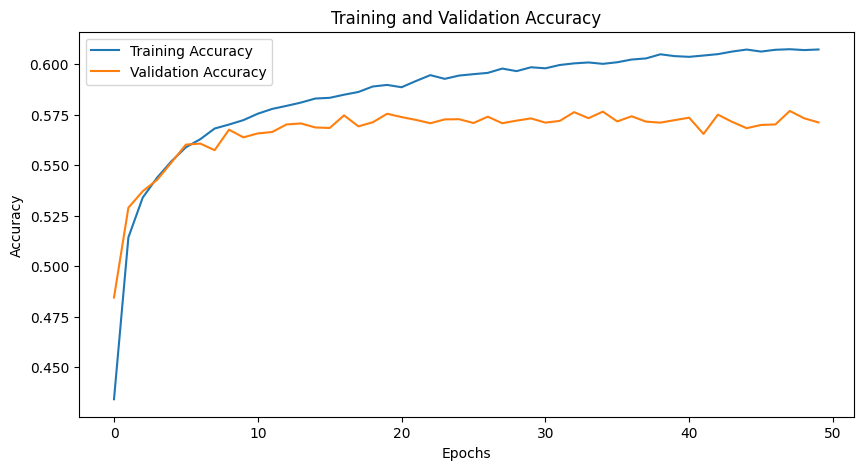

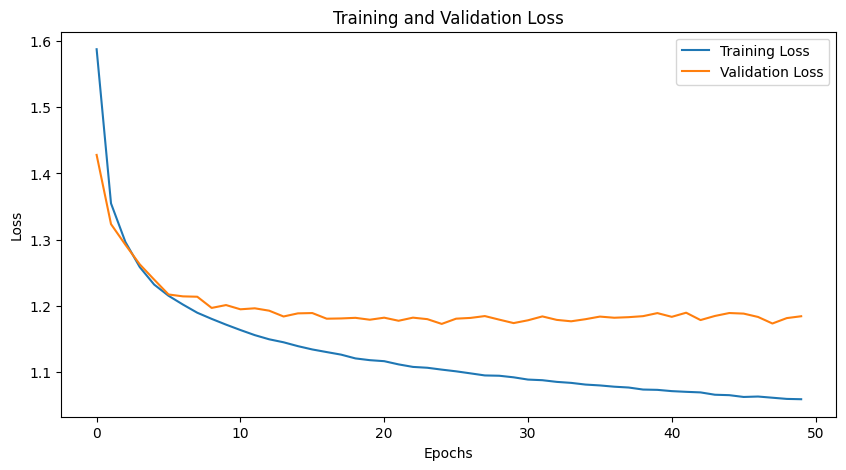

In [166]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_linkage
# Load the data (assuming it's already loaded in the DataFrame)
df = df_linkage.copy()

# Drop 'key' and 'genre'
df = df.drop(['genre'], axis=1)

# Split the data into features (X) and target (y)
X = df.drop('cluster_hierarchical', axis=1)
y = df['cluster_hierarchical']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target variable
y_encoded = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the neural network model with additional layers
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Increased neurons in the first layer
model.add(Dense(64, activation='relu'))  # Added another hidden layer with 64 neurons
model.add(Dense(32, activation='relu'))  # Added another hidden layer with 32 neurons
model.add(Dense(16, activation='relu'))  # Existing layer
model.add(Dense(8, activation='relu'))   # Added another hidden layer with 8 neurons
model.add(Dense(y_encoded.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with increased epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predictions (optional)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Neural 2 improvement 

Epoch 1/150


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - accuracy: 0.3635 - loss: 1.8133 - val_accuracy: 0.5025 - val_loss: 1.3740
Epoch 2/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step - accuracy: 0.4877 - loss: 1.4238 - val_accuracy: 0.5202 - val_loss: 1.3158
Epoch 3/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step - accuracy: 0.4967 - loss: 1.3788 - val_accuracy: 0.5239 - val_loss: 1.2952
Epoch 4/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 628us/step - accuracy: 0.5075 - loss: 1.3478 - val_accuracy: 0.5386 - val_loss: 1.2673
Epoch 5/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step - accuracy: 0.5133 - loss: 1.3252 - val_accuracy: 0.5400 - val_loss: 1.2552
Epoch 6/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.5223 - loss: 1.3098 - val_accuracy: 0.5462 - val_loss: 1.2420
Epoch 7/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - accuracy: 0.5274 - loss: 1.2981 - val_accuracy: 0.5496 - val_loss: 1.2310
Epoch 8/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 613us/step - accuracy: 0.5286 - los

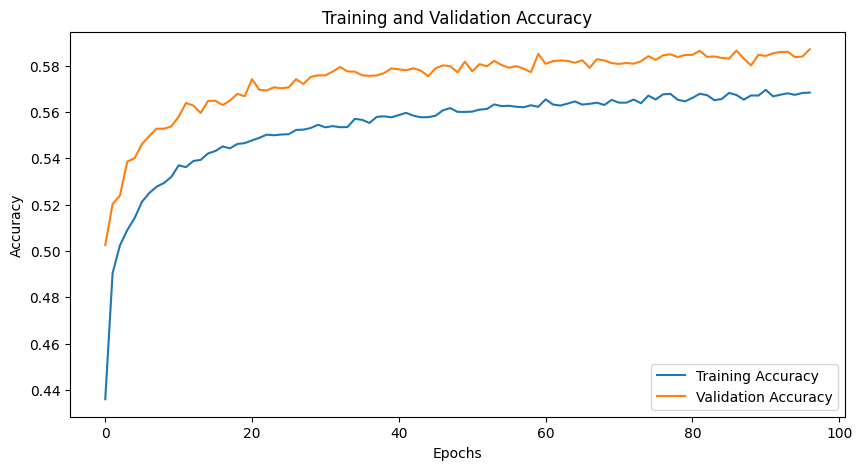

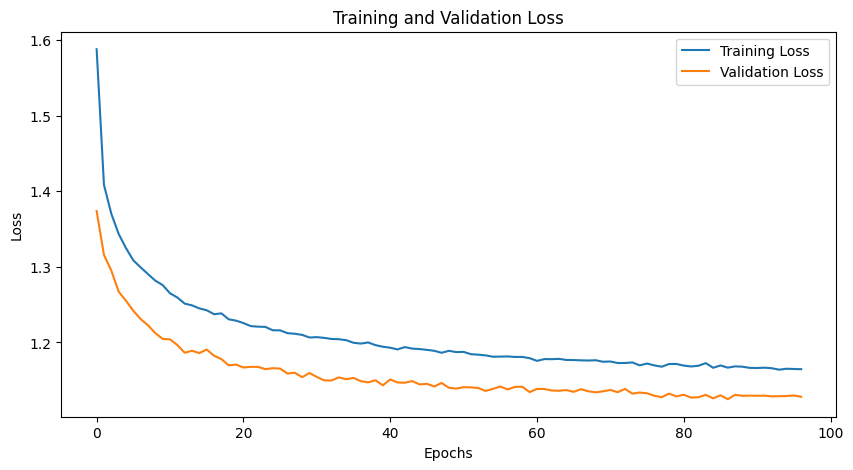

In [167]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_linkage
# Load the data (assuming it's already loaded in the DataFrame)
df = df_linkage.copy()

# Drop 'key' and 'genre'
df = df.drop(['genre'], axis=1)

# Split the data into features (X) and target (y)
X = df.drop('cluster_hierarchical', axis=1)
y = df['cluster_hierarchical']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target variable
y_encoded = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Build the neural network model with additional layers and adjusted dropout rates
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))  # Increased neurons to 256
model.add(Dropout(0.4))  # Reduced dropout rate to 0.4
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))  # Reduced dropout rate to 0.4
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Compile the model with a reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and increased epochs
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predictions (optional)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Neural 4 

Epoch 1/150


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step - accuracy: 0.3918 - loss: 1.7475 - val_accuracy: 0.5059 - val_loss: 1.3787
Epoch 2/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step - accuracy: 0.4872 - loss: 1.4155 - val_accuracy: 0.5192 - val_loss: 1.3244
Epoch 3/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 613us/step - accuracy: 0.4995 - loss: 1.3745 - val_accuracy: 0.5309 - val_loss: 1.2970
Epoch 4/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - accuracy: 0.5140 - loss: 1.3370 - val_accuracy: 0.5340 - val_loss: 1.2818
Epoch 5/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.5185 - loss: 1.3235 - val_accuracy: 0.5399 - val_loss: 1.2634
Epoch 6/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 597us/step - accuracy: 0.5199 - loss: 1.3076 - val_accuracy: 0.5425 - val_loss: 1.2509
Epoch 7/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 605us/step - accuracy: 0.5315 - loss: 1.2818 - val_accuracy: 0.5492 - val_loss: 1.2384
Epoch 8/150
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step - accuracy: 0.5303 - los

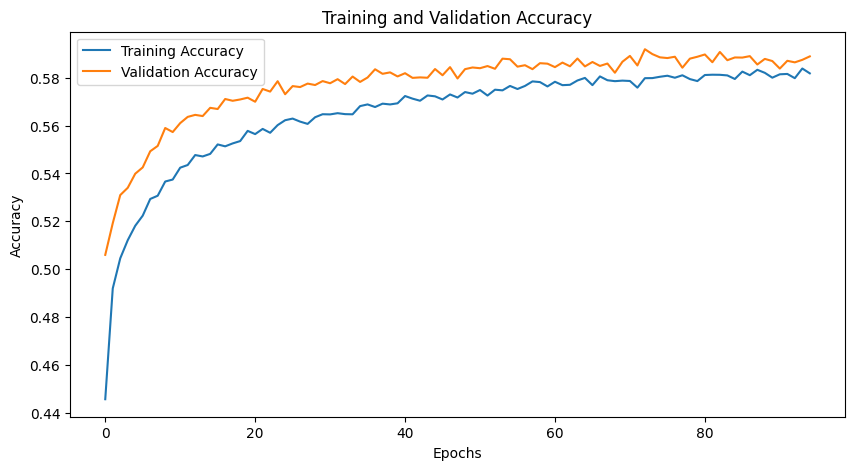

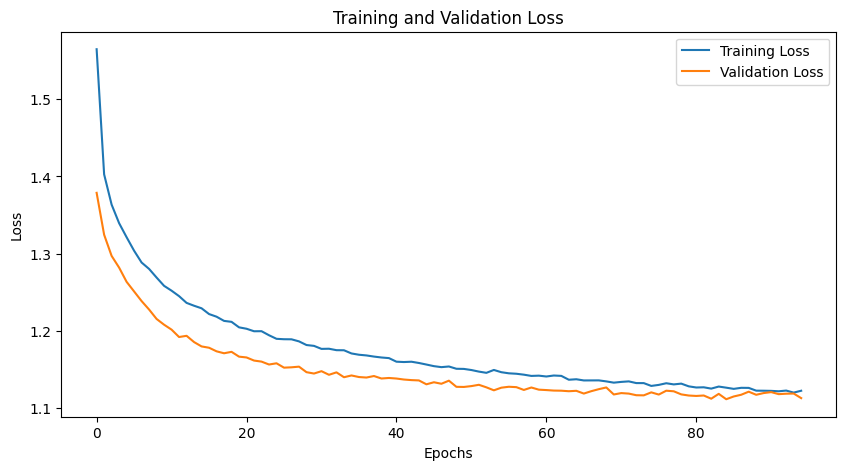

In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_linkage
# Load the data (assuming it's already loaded in the DataFrame)
df = df_linkage.copy()

# Drop 'key' and 'genre'
df = df.drop(['genre'], axis=1)

# Split the data into features (X) and target (y)
X = df.drop('cluster_hierarchical', axis=1)
y = df['cluster_hierarchical']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target variable
y_encoded = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Build the neural network model with additional layers and adjusted dropout rates
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Adjusted dropout rate to 0.3
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Adjusted dropout rate to 0.3
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Experiment with different optimizers
optimizer = Adam(learning_rate=0.0003)  # Slightly lower learning rate

# Compile the model with the chosen optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and increased epochs
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predictions (optional)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Conclusion

| **Model**                         | **Specifications**                                                                                                                                                                                   | **Accuracy** | **Strengths**                                                                                                                                        | **Limitations**                                                                                                                                                                                                                            | **Issues**                                                                                                               |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| **Random Forest Classifier**      | - Number of Trees: 100<br>- Criterion: Gini Impurity<br>- Features: Popularity, Acousticness, Danceability, Energy, etc.                                                                             | 58.85%       | - Robust to overfitting due to ensemble learning.<br>- Provides feature importance for interpretability.                                              | - Moderate performance; struggles with class imbalance.<br>- Computationally expensive with a large number of trees.<br>- Less effective with highly correlated features.                                                                 | - High computational cost.<br>- Requires careful tuning to balance bias and variance.                                    |
| **Random Forest (Tuned)**         | - Number of Trees: 200<br>- Max Depth: 20<br>- Min Samples Split: 2<br>- Min Samples Leaf: 1<br>- Bootstrap: True                                                                                     | ~59%         | - Improved performance with hyperparameter tuning.<br>- Better handling of data variability with increased tree depth.                                | - Marginal improvement over default model.<br>- Increased computational cost due to more trees and deeper depths.                                                                                                                        | - Risk of overfitting with deeper trees.<br>- Time-consuming training process.                                           |
| **XGBoost (Default)**             | - Number of Estimators: 100<br>- Learning Rate: 0.1<br>- Max Depth: 3<br>- Subsample: 1.0<br>- Objective: Multi:softmax                                                                             | ~59.77%      | - Captures complex relationships effectively.<br>- Fast training with default settings.<br>- Handles missing values well.                             | - Requires careful tuning to reach optimal performance.<br>- Default parameters might not fully utilize model's potential.                                                                                                                | - Performance depends heavily on parameter tuning.<br>- Less interpretable than simpler models.                          |
| **XGBoost (Tuned)**               | - Number of Estimators: 200<br>- Learning Rate: 0.1<br>- Max Depth: 7<br>- Subsample: 0.8<br>- Objective: Multi:softmax                                                                             | 60.24%       | - Highest accuracy among all models.<br>- Robust to overfitting with proper tuning.<br>- Effective in handling imbalanced datasets.                    | - Marginal gains with substantial tuning effort.<br>- Computationally intensive to train with larger datasets and complex parameters.                                                                                                     | - Requires careful tuning of many hyperparameters.<br>- Sensitive to noisy data and outliers.                            |
| **Support Vector Machine (SVM)**  | - Kernel: RBF<br>- Regularization Parameter (C): 1.0<br>- Gamma: Scale                                                                                                                              | 54.55%       | - Effective in high-dimensional spaces.<br>- Handles linear and non-linear separations well with the right kernel choice.                             | - Lower performance; sensitive to feature scaling and kernel choice.<br>- Not inherently suitable for multi-class problems without extensions like One-vs-All or One-vs-One strategies.                                                                                          | - High computational cost with large datasets.<br>- Requires careful selection of kernel and regularization parameters.  |
| **k-Nearest Neighbors (k-NN)**    | - Number of Neighbors (k): 5<br>- Distance Metric: Euclidean                                                                                                                                        | 50.03%       | - Simple to understand and implement.<br>- Non-parametric; does not assume data distribution.                                                        | - Lowest performance; not suitable for high-dimensional data.<br>- Sensitive to choice of k and distance metrics.<br>- Computationally expensive for large datasets.                                                                                                            | - Prone to noise and outliers.<br>- High computational cost due to distance calculations.                               |
| **Neural Network (Basic)**        | - Layers: Input (64), Hidden (32, 16), Output (Softmax)<br>- Activation: ReLU<br>- Optimizer: Adam<br>- Loss Function: Categorical Crossentropy<br>- Epochs: 50                                        | ~57.34%      | - Capable of capturing non-linear relationships.<br>- Flexible architecture to suit different problems.                                              | - Requires large amounts of data and computational resources.<br>- Less interpretable ("black box" model).<br>- Sensitive to hyperparameters like learning rate, batch size, and epochs.                                                                                       | - Risk of overfitting with complex architectures.<br>- Requires careful tuning and regularization techniques.            |
| **Neural Network (Enhanced)**     | - Layers: Input (128), Hidden (64, 32, 16), Output (Softmax)<br>- Activation: ReLU<br>- Optimizer: Adam<br>- Dropout: 0.4<br>- Learning Rate: 0.0005<br>- Early Stopping: Yes<br>- Epochs: 100       | ~58.68%      | - Improved generalization with dropout and early stopping.<br>- Reduced overfitting with lower learning rate and early stopping.                     | - Slight improvement over the basic model.<br>- Computationally expensive to train with increased layers and neurons.                                                                                                                   | - Requires fine-tuning of dropout rates and learning rate.<br>- Training time can be long with increased complexity.     |
| **Neural Network (Advanced)**     | - Layers: Input (256), Hidden (128, 64, 32, 16), Output (Softmax)<br>- Activation: ReLU<br>- Optimizer: Adam (Learning Rate: 0.0003)<br>- Dropout: 0.3<br>- Early Stopping: Yes<br>- Epochs: 150      | 58.85%       | - Further improved performance with a deeper architecture.<br>- Balanced dropout rates reduce overfitting while maintaining learning capacity.        | - Marginal gain compared to simpler models; diminishing returns with added complexity.<br>- High computational and memory requirements due to model depth and data size.                                                                                                        | - Sensitive to small changes in hyperparameters.<br>- Requires careful monitoring to avoid overfitting and underfitting. |
| **Neural Network (Best Config)**  | - Layers: Input (256), Hidden (128, 64, 32, 16), Output (Softmax)<br>- Activation: ReLU<br>- Optimizer: Adam (Learning Rate: 0.0003)<br>- Dropout: 0.3<br>- Early Stopping: Yes<br>- Epochs: 150      | 58.89%       | - Highest performance among neural networks with optimal architecture.<br>- Effective regularization and stopping criteria.<br>- Adaptive learning rate helps stabilize training.                                                   | - Computationally expensive due to deep architecture.<br>- Requires extensive tuning and validation to maintain performance.                                                                                                                                                     | - Risk of overfitting if dropout and learning rate are not well-tuned.<br>- Less interpretable than simpler models.       |


### Recommended Best Models

Let's talk about the models that stood out as the best for our music genre clustering task:

#### **XGBoost (Tuned)**

**Why should we keep it?**

- **Highest Accuracy**: After tuning the hyperparameters, XGBoost achieved the highest accuracy at 60.24%. This is better than any other model we tested.
- **Robust to Overfitting**: XGBoost does a great job balancing bias and variance with the right tuning, making it less likely to overfit, even when dealing with complex datasets.
- **Feature Importance**: One of the great things about XGBoost is that it provides feature importance metrics. This helps us interpret the model and understand which features are most influential in making predictions.
- **Handling Imbalance**: XGBoost is also quite robust when it comes to handling imbalanced data. This is particularly useful in our case if some clusters are not as well represented as others.
- **Use Cases**: It's the go-to model when prediction accuracy is the top priority, and we have enough computational resources to manage its training demands.

#### **Neural Network (Advanced with Early Stopping and Dropout)**

**Why should we keep it?**

- **Competitive Performance**: The advanced neural network configuration gave us an accuracy that's quite close to XGBoost, coming in at 58.89%. It shows strong performance, especially in capturing non-linear relationships in the data.
- **Flexibility in Modeling**: Neural networks are incredibly flexible. We can adjust the architecture—like the number of layers, neurons, and activation functions—to match the complexity of our data.
- **Overfitting Prevention**: With techniques like dropout and early stopping, the model is better at preventing overfitting. This maintains a good balance between having enough capacity to learn and generalizing well to new data.
- **Use Cases**: Neural networks are ideal when we need to understand complex, non-linear patterns. And even though they are less interpretable than simpler models, we can supplement them with interpretability techniques like SHAP or LIME.

In conclusion, **XGBoost (Tuned)** and the **Advanced Neural Network** are the models to go forward with. They both offer the right mix of performance, flexibility, and robustness, making them suitable for further development and deployment in our predictive tasks.


# Sub-modeling

## Cluster 1 

In [175]:
df_1 = df_linkage[df_linkage['cluster_hierarchical'] == 1]

df_1['genre'].unique()

array(['punk-rock', 'punk', 'grunge', 'metal', 'industrial',
       'world-music', 'metalcore', 'goth', 'death-metal', 'breakbeat',
       'black-metal', 'j-idol', 'gospel', 'drum-and-bass', 'dubstep',
       'heavy-metal', 'happy', 'hardstyle'], dtype=object)

               popularity  duration_ms  danceability    energy       key  \
genre                                                                      
black-metal     -0.982775     1.585126     -2.415860  0.527021  1.963716   
breakbeat       -1.346766     1.320138      2.140132  0.301809 -0.679042   
death-metal     -0.545986    -0.300986     -1.472489  1.062562 -0.679042   
drum-and-bass   -0.982775     1.046680      0.691300  0.540444 -0.679042   
dubstep          0.909977    -1.002580      0.504390 -0.534565 -0.679042   

               loudness  speechiness  acousticness  instrumentalness  \
genre                                                                  
black-metal   -0.741651     0.027174     -0.451236          2.822730   
breakbeat     -0.373246    -0.202076     -0.404211          1.989295   
death-metal    0.272068     1.005449     -0.450192          0.054535   
drum-and-bass  1.309992     0.109578     -0.412343          1.669315   
dubstep        0.343716     0.21944

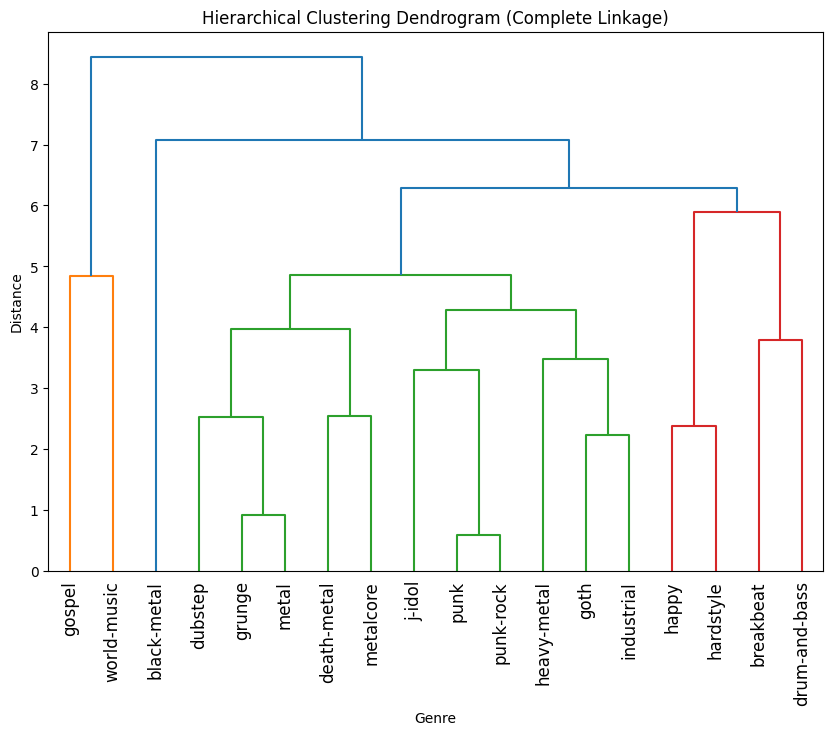

/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/1376199821.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genres_per_cluster = genre_clustered_df.groupby('cluster_hierarchical').apply(lambda x: list(x.index.get_level_values(0)))
/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/1376199821.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['cluster_second'] = df_1['genre'].map(genre_to_cluster)


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,cluster_hierarchical,cluster_second
174,61,235813,0.470,0.801,9,-6.426,1,0.0352,0.0758,0.000035,0.218,0.431,173.920,punk-rock,1,2
175,61,235813,0.470,0.801,9,-6.426,1,0.0352,0.0758,0.000035,0.218,0.431,173.920,punk,1,2
177,61,228933,0.564,0.864,4,-5.121,1,0.0341,0.0761,0.000000,0.182,0.534,95.984,punk-rock,1,2
178,61,228933,0.564,0.864,4,-5.121,1,0.0341,0.0761,0.000000,0.182,0.534,95.984,punk,1,2
211,55,216853,0.606,0.540,7,-6.271,0,0.0339,0.1820,0.000144,0.144,0.249,79.952,punk-rock,1,2


In [176]:
import pandas as pd

# Assuming df_linkage is your DataFrame

custom_aggregation = {
    'popularity': 'median',
    'duration_ms': 'median',
    'danceability': 'mean',
    'energy': 'mean',
    'key': lambda x: x.mode()[0],  # Mode for categorical data
    'loudness': 'median',
    'speechiness': lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR for spread
    'acousticness': 'median',
    'instrumentalness': 'median',
    'liveness': lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR for spread
    'valence': 'mean',
    'tempo': 'std',  # Standard Deviation for variability
}

# Group by 'genre' and apply custom aggregation
genre_aggregated = df_1.groupby('genre').agg(custom_aggregation)


from sklearn.preprocessing import StandardScaler

# Standardize the aggregated data
scaler = StandardScaler()
genre_scaled = scaler.fit_transform(genre_aggregated)

# Convert back to DataFrame for easier interpretation
genre_scaled_df = pd.DataFrame(genre_scaled, index=genre_aggregated.index, columns=genre_aggregated.columns)
print(genre_scaled_df.head())

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Apply complete linkage hierarchical clustering
Z = linkage(genre_scaled_df, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=genre_scaled_df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Genre')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Specify the number of clusters you want
num_clusters = 3  # Change this value to your desired number of clusters

# Form flat clusters by specifying the number of clusters
genre_clusters = fcluster(Z, t=num_clusters, criterion='maxclust')

# Add the cluster labels to the genre DataFrame
genre_clustered_df = genre_aggregated.copy()
genre_clustered_df['cluster_hierarchical'] = genre_clusters

# Display the resulting clusters sorted by cluster labels
#genre_clustered_df[['cluster_hierarchical']].sort_values(by='cluster_hierarchical')
# Group by cluster labels and list the genres in each cluster, selecting columns after groupby
genres_per_cluster = genre_clustered_df.groupby('cluster_hierarchical').apply(lambda x: list(x.index.get_level_values(0)))

# Convert to DataFrame for easier interpretation
genres_per_cluster_df = pd.DataFrame(genres_per_cluster, columns=['genres'])

# Display the genres in each cluster
genres_per_cluster_df

# First, create a mapping from the genre to the cluster label
genre_to_cluster = genre_clustered_df['cluster_hierarchical'].to_dict()

# Add the cluster_hierarchical column to df_linkage based on the genre
df_1['cluster_second'] = df_1['genre'].map(genre_to_cluster)

# Display the first few rows to verify
df_1.head()


In [172]:
genres_per_cluster_df

,genres
cluster_hierarchical,
1,"[gospel, world-music]"
2,"[breakbeat, death-metal, drum-and-bass, dubste..."
3,[black-metal]


### Random Forrest 0.9274

In [180]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define features (X) and labels (y)
X = df_1.drop(columns=['cluster_hierarchical', 'cluster_second','genre'])
y = df_1['cluster_second']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators = 500,random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print the classification report for detailed performance metrics
print(classification_report(y_test, y_pred))

# Feature importance (optional, to understand which features are most influential)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


Accuracy: 0.9224
              precision    recall  f1-score   support

           1       0.87      0.70      0.78       382
           2       0.93      0.98      0.96      2796
           3       0.88      0.49      0.63       197

    accuracy                           0.92      3375
   macro avg       0.89      0.73      0.79      3375
weighted avg       0.92      0.92      0.92      3375

             Feature  Importance
8       acousticness    0.132725
0         popularity    0.127102
3             energy    0.126649
2       danceability    0.103321
9   instrumentalness    0.095801
1        duration_ms    0.086096
7        speechiness    0.069477
11           valence    0.066300
5           loudness    0.062378
12             tempo    0.048071
10          liveness    0.045909
4                key    0.023232
6               mode    0.012940


### XGboost 0.9254

In [182]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Define features (X) and labels (y)
X = df_1.drop(columns=['cluster_hierarchical', 'cluster_second','genre'])
y = df_1['cluster_second']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the target labels for XGBoost
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialize XGBoost model with the best parameters
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=200,
    subsample=0.8
)

# Train the model
xgb_model.fit(X_train_scaled, y_train_adjusted)

# Make predictions
y_pred_adjusted = xgb_model.predict(X_test_scaled)
y_pred = y_pred_adjusted + 1  # Adjust predictions back to original labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Parameters: {accuracy:.4f}")

# Optionally, print classification report
#print(classification_report(y_test, y_pred))


Test Accuracy with Best Parameters: 0.9271


### Neural 0.9216

Epoch 1/150


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.7654 - loss: 0.6849 - val_accuracy: 0.8803 - val_loss: 0.3211
Epoch 2/150
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.8745 - loss: 0.3376 - val_accuracy: 0.8839 - val_loss: 0.2933
Epoch 3/150
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.8787 - loss: 0.3092 - val_accuracy: 0.8877 - val_loss: 0.2844
Epoch 4/150
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.8754 - loss: 0.3078 - val_accuracy: 0.8913 - val_loss: 0.2772
Epoch 5/150
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.8842 - loss: 0.2881 - val_accuracy: 0.8913 - val_loss: 0.2762
Epoch 6/150
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.8889 - loss: 0.2838 - val_accuracy: 0.8924 - val_loss: 0.2719
Epoch 7/150
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.8866 - loss: 0.2870 - val_accuracy: 0.9001 - val_loss: 0.2656
Epoch 8/150
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.8929 - loss: 0.2655 - val_

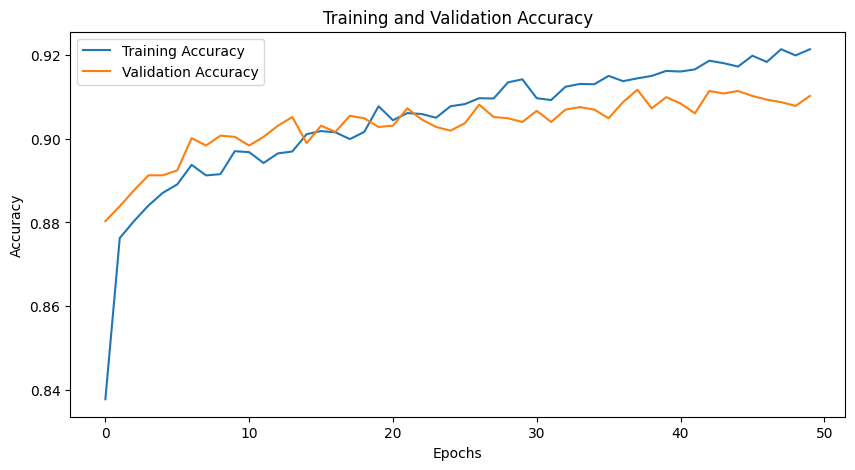

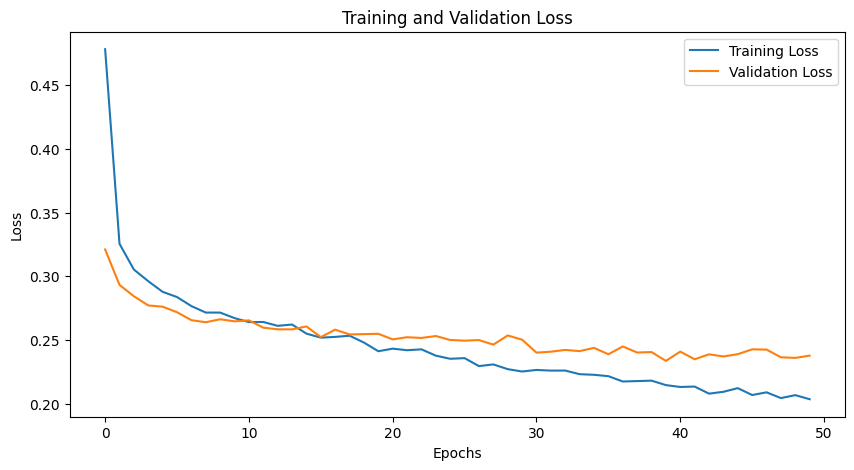

In [183]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_linkage
# Load the data (assuming it's already loaded in the DataFrame)
df = df_1.copy()

# Drop 'key' and 'genre'
df = df.drop(['key'], axis=1)

# Define features (X) and labels (y)
X = df_1.drop(columns=['cluster_hierarchical', 'cluster_second','genre'])
y = df_1['cluster_second']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target variable
y_encoded = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Build the neural network model with additional layers and adjusted dropout rates
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Adjusted dropout rate to 0.3
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Adjusted dropout rate to 0.3
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Experiment with different optimizers
optimizer = Adam(learning_rate=0.0003)  # Slightly lower learning rate

# Compile the model with the chosen optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and increased epochs
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predictions (optional)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Cluster 2 

In [192]:
df_2 = df_linkage[df_linkage['cluster_hierarchical'] == 2]

df_2['genre'].unique()

df_2['cluster_second'] = 0


/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/1154232154.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['cluster_second'] = 0


## Cluster 3 

In [197]:
df_3 = df_linkage[df_linkage['cluster_hierarchical'] == 3]

df_3['genre'].unique()

df_3['cluster_second'] = 0


/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/3298254302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['cluster_second'] = 0


## Cluster 4 

In [201]:
df_4 = df_linkage[df_linkage['cluster_hierarchical'] == 4]

df_4['genre'].unique()

df_4['cluster_second'] = 0


/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/3002094700.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['cluster_second'] = 0


## Cluster 5

In [204]:
df_5 = df_linkage[df_linkage['cluster_hierarchical'] == 5]

df_5['genre'].unique()

df_5['cluster_second'] = 0



/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/2319978595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['cluster_second'] = 0


## Cluster 6

In [207]:
df_6 = df_linkage[df_linkage['cluster_hierarchical'] == 6]

df_6['genre'].unique()

df_6['cluster_second'] = 0



/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/1007700274.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6['cluster_second'] = 0


## Cluster 7

In [209]:
df_7 = df_linkage[df_linkage['cluster_hierarchical'] == 7]

df_7['genre'].unique()


array(['acoustic', 'singer-songwriter', 'songwriter', 'chill',
       'indie-pop', 'folk', 'jazz', 'british', 'malay', 'dub', 'indie',
       'pop', 'electro', 'turkish', 'electronic', 'emo', 'anime',
       'german', 'indian', 'house', 'french', 'club', 'k-pop', 'sad',
       'rock-n-roll', 'children', 'cantopop', 'mandopop', 'pop-film',
       'forro'], dtype=object)

          popularity  duration_ms  danceability    energy       key  loudness  \
genre                                                                           
acoustic   -0.040760     0.235498     -0.936694 -1.209415 -0.547270 -0.733216   
anime       0.264939     0.193869     -1.154163  0.884342  0.199007  1.171070   
british     0.468737     0.054463     -1.979349 -0.666474 -0.547270 -1.044867   
cantopop   -1.263553     0.932892     -0.979589 -0.972365 -0.547270 -0.842454   
children   -1.161654    -2.440288      2.170972 -0.681364 -0.547270 -0.596989   

          speechiness  acousticness  instrumentalness  liveness   valence  \
genre                                                                       
acoustic    -0.999695      1.503117         -0.201430 -1.209227 -0.433048   
anime        0.320025     -1.259668         -0.201036  1.151897 -0.384591   
british     -0.929913      0.234876         -0.184196 -0.483382 -0.391494   
cantopop    -1.159196      1.003364         -0.

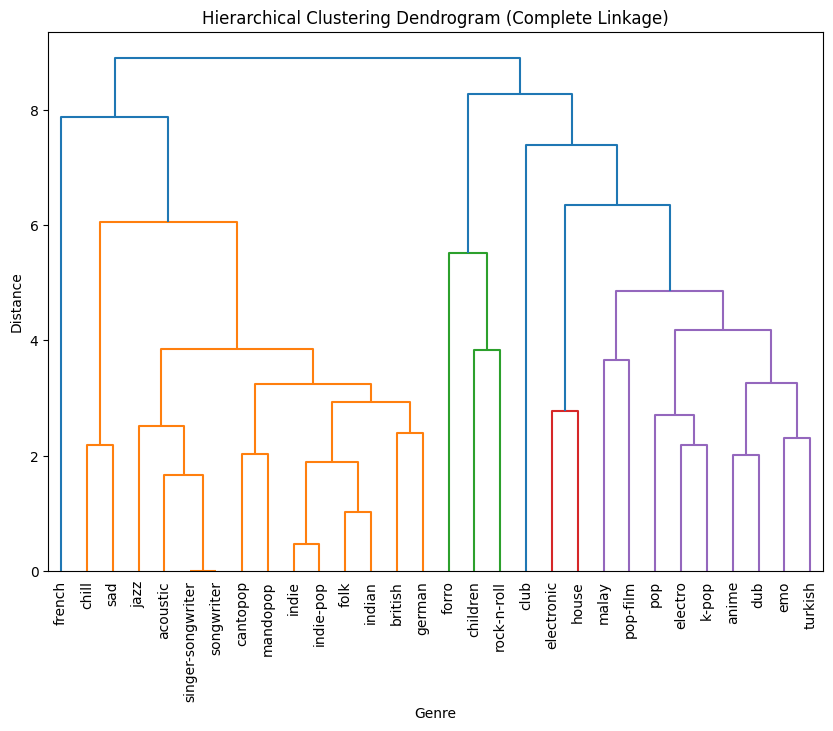

/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/4165029884.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genres_per_cluster = genre_clustered_df.groupby('cluster_hierarchical').apply(lambda x: list(x.index.get_level_values(0)))
/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/4165029884.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7['cluster_second'] = df_7['genre'].map(genre_to_cluster)


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,cluster_hierarchical,cluster_second
0,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,acoustic,7,1
2,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,singer-songwriter,7,1
3,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,songwriter,7,1
4,55,149610,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,acoustic,7,1
5,55,149610,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,chill,7,1


In [211]:
import pandas as pd

# Assuming df_linkage is your DataFrame

custom_aggregation = {
    'popularity': 'median',
    'duration_ms': 'median',
    'danceability': 'mean',
    'energy': 'mean',
    'key': lambda x: x.mode()[0],  # Mode for categorical data
    'loudness': 'median',
    'speechiness': lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR for spread
    'acousticness': 'median',
    'instrumentalness': 'median',
    'liveness': lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR for spread
    'valence': 'mean',
    'tempo': 'std',  # Standard Deviation for variability
}

# Group by 'genre' and apply custom aggregation
genre_aggregated = df_7.groupby('genre').agg(custom_aggregation)


from sklearn.preprocessing import StandardScaler

# Standardize the aggregated data
scaler = StandardScaler()
genre_scaled = scaler.fit_transform(genre_aggregated)

# Convert back to DataFrame for easier interpretation
genre_scaled_df = pd.DataFrame(genre_scaled, index=genre_aggregated.index, columns=genre_aggregated.columns)
print(genre_scaled_df.head())

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Apply complete linkage hierarchical clustering
Z = linkage(genre_scaled_df, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=genre_scaled_df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Genre')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Specify the number of clusters you want
num_clusters = 6  # Change this value to your desired number of clusters

# Form flat clusters by specifying the number of clusters
genre_clusters = fcluster(Z, t=num_clusters, criterion='maxclust')

# Add the cluster labels to the genre DataFrame
genre_clustered_df = genre_aggregated.copy()
genre_clustered_df['cluster_hierarchical'] = genre_clusters

# Display the resulting clusters sorted by cluster labels
#genre_clustered_df[['cluster_hierarchical']].sort_values(by='cluster_hierarchical')
# Group by cluster labels and list the genres in each cluster, selecting columns after groupby
genres_per_cluster = genre_clustered_df.groupby('cluster_hierarchical').apply(lambda x: list(x.index.get_level_values(0)))

# Convert to DataFrame for easier interpretation
genres_per_cluster_df = pd.DataFrame(genres_per_cluster, columns=['genre'])

# Display the genres in each cluster
genres_per_cluster_df

# First, create a mapping from the genre to the cluster label
genre_to_cluster = genre_clustered_df['cluster_hierarchical'].to_dict()

# Add the cluster_hierarchical column to df_linkage based on the genre
df_7['cluster_second'] = df_7['genre'].map(genre_to_cluster)


# Display the first few rows to verify
df_7.head()


In [212]:
genres_per_cluster_df

,genre
cluster_hierarchical,
1,"[acoustic, british, cantopop, chill, folk, ger..."
2,[french]
3,"[children, forro, rock-n-roll]"
4,"[electronic, house]"
5,"[anime, dub, electro, emo, k-pop, malay, pop, ..."
6,[club]


### Random Forrest 

In [217]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define features (X) and labels (y)
X = df_7.drop(columns=['cluster_hierarchical','cluster_second', 'genre'])
y = df_7['cluster_second']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators = 500,random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print the classification report for detailed performance metrics
print(classification_report(y_test, y_pred))

# Feature importance (optional, to understand which features are most influential)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


Accuracy: 0.6501
              precision    recall  f1-score   support

           1       0.69      0.82      0.75      2417
           2       0.50      0.08      0.14       189
           3       0.76      0.62      0.68       505
           4       0.29      0.13      0.18       320
           5       0.58      0.61      0.60      1643
           6       0.65      0.39      0.49       187

    accuracy                           0.65      5261
   macro avg       0.58      0.44      0.47      5261
weighted avg       0.63      0.65      0.63      5261

             Feature  Importance
11           valence    0.100909
0         popularity    0.099410
1        duration_ms    0.097530
3             energy    0.097292
8       acousticness    0.094401
5           loudness    0.087738
7        speechiness    0.081290
2       danceability    0.075119
12             tempo    0.070873
10          liveness    0.068619
9   instrumentalness    0.067794
4                key    0.041377
6          

### XGboost

In [216]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Define features (X) and labels (y)
X = df_7.drop(columns=['cluster_hierarchical','cluster_second', 'genre'])
y = df_7['cluster_second']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the target labels for XGBoost
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialize XGBoost model with the best parameters
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=200,
    subsample=0.8
)

# Train the model
xgb_model.fit(X_train_scaled, y_train_adjusted)

# Make predictions
y_pred_adjusted = xgb_model.predict(X_test_scaled)
y_pred = y_pred_adjusted + 1  # Adjust predictions back to original labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Parameters: {accuracy:.4f}")

# Optionally, print classification report
#print(classification_report(y_test, y_pred))


Test Accuracy with Best Parameters: 0.6757


### Neural 0.9316

Epoch 1/200


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.4109 - loss: 1.4845 - val_accuracy: 0.5754 - val_loss: 1.0843
Epoch 2/200
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.5666 - loss: 1.1119 - val_accuracy: 0.5721 - val_loss: 1.0602
Epoch 3/200
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.5725 - loss: 1.0833 - val_accuracy: 0.5900 - val_loss: 1.0230
Epoch 4/200
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.5876 - loss: 1.0588 - val_accuracy: 0.5930 - val_loss: 1.0159
Epoch 5/200
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.5814 - loss: 1.0554 - val_accuracy: 0.6035 - val_loss: 1.0017
Epoch 6/200
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.5969 - loss: 1.0405 - val_accuracy: 0.5984 - val_loss: 0.9999
Epoch 7/200
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.5998 - loss: 1.0291 - val_accuracy: 0.6024 - val_loss: 0.9965
Epoch 8/200
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.5964 - loss: 1.0169 - val_

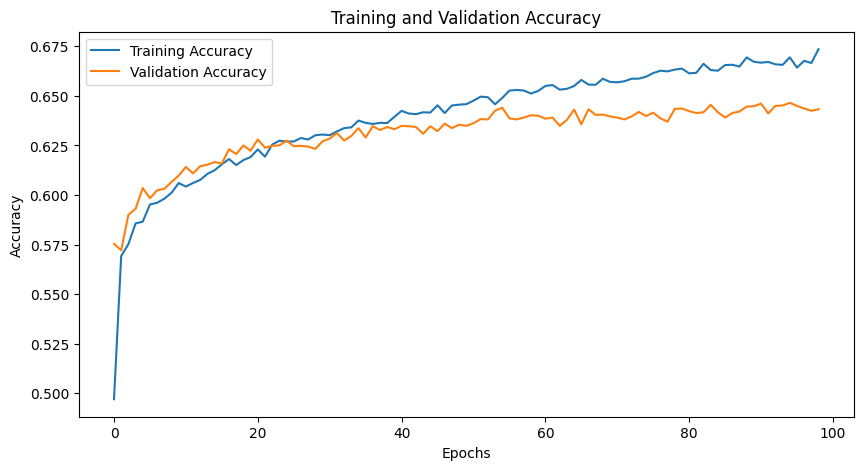

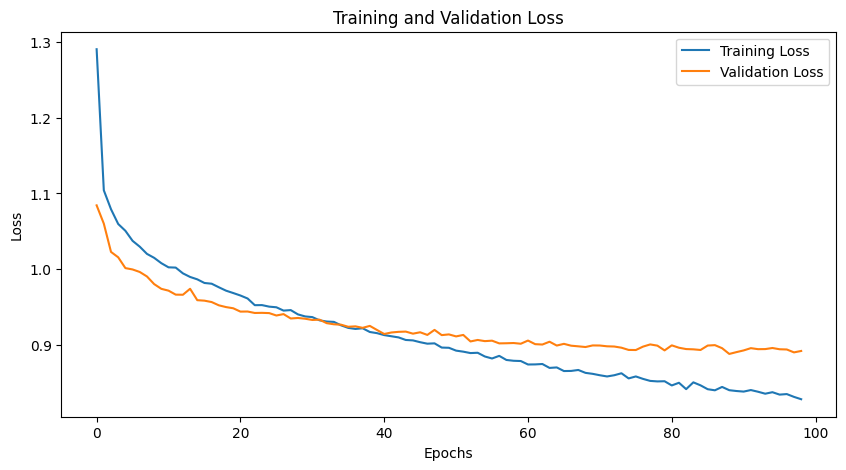

In [218]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_linkage
# Load the data (assuming it's already loaded in the DataFrame)
df = df_7.copy()

# Split the data into features (X) and target (y)
X = df.drop(columns=['cluster_hierarchical', 'cluster_second','genre'])
y = df['cluster_second']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target variable
y_encoded = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Build the neural network model with additional layers and adjusted dropout rates
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Adjusted dropout rate to 0.3
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Adjusted dropout rate to 0.3
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Experiment with different optimizers
optimizer = Adam(learning_rate=0.0003)  # Slightly lower learning rate

# Compile the model with the chosen optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping and increased epochs
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predictions (optional)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Cluster 8

In [226]:
df_8 = df_linkage[df_linkage['cluster_hierarchical'] == 8]

df_8['genre'].unique()

df_8['cluster_second'] = 0



/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/3796381341.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8['cluster_second'] = 0


## Cluster 9

In [227]:
df_9 = df_linkage[df_linkage['cluster_hierarchical'] == 9]

df_9['genre'].unique()

df_9['cluster_second'] = 0



/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/3351991711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9['cluster_second'] = 0


## Cluster 10

In [228]:
df_10 = df_linkage[df_linkage['cluster_hierarchical'] == 10]

df_10['genre'].unique()

df_10['cluster_second'] = 0


/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/135123447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10['cluster_second'] = 0


## Cluster 11

In [229]:
df_11 = df_linkage[df_linkage['cluster_hierarchical'] == 11]

df_11['genre'].unique()

df_11['cluster_second'] = 0


/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/2995770390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_11['cluster_second'] = 0


## Cluster 12

In [230]:
df_12 = df_linkage[df_linkage['cluster_hierarchical'] == 12]

df_12['genre'].unique()

df_12['cluster_second'] = 0


/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_44540/766870687.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['cluster_second'] = 0


# Merge Data

In [231]:
import pandas as pd

# Assuming df_1, df_2, ..., df_8 are already defined
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8,df_9,df_10,df_11,df_12]

# Concatenate DataFrames without resetting the index
result_df = pd.concat(dfs, ignore_index=False)

# Sort the concatenated DataFrame by its index
result_df_sorted = result_df.sort_index()

# Display the resulting sorted DataFrame
result_df_sorted.head()


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,cluster_hierarchical,cluster_second
0,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,acoustic,7,1
1,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,j-pop,8,0
2,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,singer-songwriter,7,1
3,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,songwriter,7,1
4,55,149610,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,acoustic,7,1


In [232]:
result_df_sorted.to_csv('result_df_sorted.csv', index=False)


# Final Layered Model 

In [237]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import numpy as np

# Load and preprocess the data
df = pd.read_csv('result_df_sorted.csv')

# Ensure no NaN values and proper indexing
df = df.dropna().reset_index(drop=True)

# Define features (X) and labels (y) for the initial XGBoost model
X = df.drop(columns=['cluster_hierarchical', 'genre', 'cluster_second'])
y = df['cluster_hierarchical']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler and fit on the training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust target labels for XGBoost (ensure labels start from 0)
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialize XGBoost model with best parameters
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8
)

# Train the initial model to predict cluster_hierarchical
xgb_model.fit(X_train_scaled, y_train_adjusted)

# Make predictions and adjust back to original labels
y_pred_adjusted = xgb_model.predict(X_test_scaled)
y_pred_initial = y_pred_adjusted + 1

# Calculate accuracy and print classification report for the initial model
accuracy_initial = accuracy_score(y_test, y_pred_initial)
print(f"Initial Model Accuracy with Best Parameters: {accuracy_initial:.4f}")
print("Initial Model Classification Report:")
print(classification_report(y_test, y_pred_initial))

# Prepare data for refinement models for specified clusters
refinement_models = {}
clusters_to_refine = [1, 7]

for cluster in clusters_to_refine:
    print(f"\nRefining model for cluster_hierarchical = {cluster}")
    
    # Filter data for the specific cluster
    df_cluster = df[df['cluster_hierarchical'] == cluster]
    
    # Define features and labels for the cluster-specific model
    X_cluster = df_cluster.drop(columns=['cluster_hierarchical', 'genre', 'cluster_second'])
    y_cluster = df_cluster['cluster_second']
    
    # Adjust labels to start from 0
    y_cluster_adjusted = y_cluster - y_cluster.min()
    
    # Split the data into training and testing sets for the cluster-specific model
    X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(
        X_cluster, y_cluster_adjusted, test_size=0.2, random_state=42
    )
    
    # Standardize features using the same scaler strategy
    X_train_cluster_scaled = scaler.fit_transform(X_train_cluster)
    X_test_cluster_scaled = scaler.transform(X_test_cluster)
    
    # Initialize and train the XGBoost model for the cluster
    xgb_cluster_model = XGBClassifier(
        eval_metric='mlogloss',
        random_state=42,
        learning_rate=0.1,
        max_depth=7,
        n_estimators=200,
        subsample=0.8
    )
    
    xgb_cluster_model.fit(X_train_cluster_scaled, y_train_cluster)
    
    # Store the model in the dictionary
    refinement_models[cluster] = xgb_cluster_model

    # Make predictions with the refined model
    y_pred_cluster = xgb_cluster_model.predict(X_test_cluster_scaled)
    
    # Adjust predictions back to original labels
    y_pred_cluster_original = y_pred_cluster + y_cluster.min()
    
    # Calculate accuracy for the refined model
    accuracy_cluster = accuracy_score(y_test_cluster + y_cluster.min(), y_pred_cluster_original)
    print(f"Refined Model Accuracy for cluster_hierarchical = {cluster}: {accuracy_cluster:.4f}")
    print(f"Refined Model Classification Report for cluster_hierarchical = {cluster}:")
    print(classification_report(y_test_cluster + y_cluster.min(), y_pred_cluster_original))

# Final Predictions using the two-layer model approach
final_predictions = y_pred_initial.copy()

for i, pred in enumerate(y_pred_initial):
    if pred in clusters_to_refine:
        # Use the corresponding refined model for clusters 1 or 7
        sub_model = refinement_models.get(pred)
        if sub_model:
            # Extract features for a single sample
            sub_model_features = X_test.iloc[i:i+1]
            refined_pred = sub_model.predict(scaler.transform(sub_model_features))
            
            # Convert refined prediction back to the original cluster_second range
            refined_pred_original = refined_pred[0] + df[df['cluster_hierarchical'] == pred]['cluster_second'].min()
            final_predictions[i] = refined_pred_original

# Evaluate the combined model
accuracy_final = accuracy_score(y_test, final_predictions)
print(f"\nFinal Combined Model Accuracy: {accuracy_final:.4f}")
print("Final Combined Model Classification Report:")
print(classification_report(y_test, final_predictions))

print("\nTwo-Layer Model Execution Completed.")


Initial Model Accuracy with Best Parameters: 0.6024
Initial Model Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.68      0.67      3462
           2       0.70      0.61      0.65       364
           3       0.92      0.88      0.90       197
           4       0.67      0.60      0.63       770
           5       0.52      0.42      0.47      1310
           6       0.61      0.47      0.53      1491
           7       0.57      0.67      0.61      5358
           8       0.48      0.45      0.47      3761
           9       0.74      0.71      0.73       760
          10       0.73      0.71      0.72      1322
          11       0.69      0.63      0.66      1065
          12       0.95      0.82      0.88       182

    accuracy                           0.60     20042
   macro avg       0.69      0.64      0.66     20042
weighted avg       0.60      0.60      0.60     20042


Refining model for cluster_hierarchical = 1

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [238]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import numpy as np

# Load and preprocess the data
df = pd.read_csv('result_df_sorted.csv')

# Ensure no NaN values and proper indexing
df = df.dropna().reset_index(drop=True)

# Define features (X) and labels (y) for the initial XGBoost model
X = df.drop(columns=['cluster_hierarchical', 'genre', 'cluster_second'])
y = df['cluster_hierarchical']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler and fit on the training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust target labels for XGBoost (ensure labels start from 0)
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialize XGBoost model with best parameters
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8
)

# Train the initial model to predict cluster_hierarchical
xgb_model.fit(X_train_scaled, y_train_adjusted)

# Make predictions and adjust back to original labels
y_pred_adjusted = xgb_model.predict(X_test_scaled)
y_pred_initial = y_pred_adjusted + 1

# Calculate accuracy and print classification report for the initial model
accuracy_initial = accuracy_score(y_test, y_pred_initial)
print(f"Initial Model Accuracy with Best Parameters: {accuracy_initial:.4f}")
print("Initial Model Classification Report:")
print(classification_report(y_test, y_pred_initial))

# Prepare data for refinement models for specified clusters
refinement_models = {}
clusters_to_refine = [1, 7]

for cluster in clusters_to_refine:
    print(f"\nRefining model for cluster_hierarchical = {cluster}")
    
    # Filter data for the specific cluster
    df_cluster = df[df['cluster_hierarchical'] == cluster]
    
    # Define features and labels for the cluster-specific model
    X_cluster = df_cluster.drop(columns=['cluster_hierarchical', 'genre', 'cluster_second'])
    y_cluster = df_cluster['cluster_second']
    
    # Adjust labels to start from 0
    y_cluster_adjusted = y_cluster - y_cluster.min()
    
    # Split the data into training and testing sets for the cluster-specific model
    X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(
        X_cluster, y_cluster_adjusted, test_size=0.2, random_state=42
    )
    
    # Standardize features using the same scaler strategy
    X_train_cluster_scaled = scaler.fit_transform(X_train_cluster)
    X_test_cluster_scaled = scaler.transform(X_test_cluster)
    
    # Initialize and train the XGBoost model for the cluster
    xgb_cluster_model = XGBClassifier(
        eval_metric='mlogloss',
        random_state=42,
        learning_rate=0.1,
        max_depth=7,
        n_estimators=200,
        subsample=0.8
    )
    
    xgb_cluster_model.fit(X_train_cluster_scaled, y_train_cluster)
    
    # Store the model in the dictionary
    refinement_models[cluster] = xgb_cluster_model

    # Make predictions with the refined model
    y_pred_cluster = xgb_cluster_model.predict(X_test_cluster_scaled)
    
    # Adjust predictions back to original labels
    y_pred_cluster_original = y_pred_cluster + y_cluster.min()
    
    # Calculate accuracy for the refined model
    accuracy_cluster = accuracy_score(y_test_cluster + y_cluster.min(), y_pred_cluster_original)
    print(f"Refined Model Accuracy for cluster_hierarchical = {cluster}: {accuracy_cluster:.4f}")
    print(f"Refined Model Classification Report for cluster_hierarchical = {cluster}:")
    print(classification_report(y_test_cluster + y_cluster.min(), y_pred_cluster_original))

# Final Predictions using the two-layer model approach
final_predictions = y_pred_initial.copy()

for i, pred in enumerate(y_pred_initial):
    if pred in clusters_to_refine:
        # Use the corresponding refined model for clusters 1 or 7
        sub_model = refinement_models.get(pred)
        if sub_model:
            # Extract features for a single sample
            sub_model_features = X_test.iloc[i:i+1]
            refined_pred = sub_model.predict(scaler.transform(sub_model_features))
            
            # Convert refined prediction back to the original cluster_second range
            refined_pred_original = refined_pred[0] + df[df['cluster_hierarchical'] == pred]['cluster_second'].min()
            final_predictions[i] = refined_pred_original

# Evaluate the combined model
accuracy_final = accuracy_score(y_test, final_predictions)
print(f"\nFinal Combined Model Accuracy: {accuracy_final:.4f}")
print("Final Combined Model Classification Report:")
print(classification_report(y_test, final_predictions))

print("\nTwo-Layer Model Execution Completed.")


Initial Model Accuracy with Best Parameters: 0.6024
Initial Model Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.68      0.67      3462
           2       0.70      0.61      0.65       364
           3       0.92      0.88      0.90       197
           4       0.67      0.60      0.63       770
           5       0.52      0.42      0.47      1310
           6       0.61      0.47      0.53      1491
           7       0.57      0.67      0.61      5358
           8       0.48      0.45      0.47      3761
           9       0.74      0.71      0.73       760
          10       0.73      0.71      0.72      1322
          11       0.69      0.63      0.66      1065
          12       0.95      0.82      0.88       182

    accuracy                           0.60     20042
   macro avg       0.69      0.64      0.66     20042
weighted avg       0.60      0.60      0.60     20042


Refining model for cluster_hierarchical = 1

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In our analysis, hierarchical clustering was employed to group music genres based on shared characteristics, revealing natural clusters within the data. This unsupervised learning approach was particularly valuable for exploratory analysis, as it allowed us to discover patterns and relationships among genres without needing predefined labels. The method successfully identified meaningful groupings that align with musical and cultural similarities, such as clustering 'metal' subgenres together or combining various dance-related genres. Moreover, the flexibility of hierarchical clustering in choosing the granularity of clusters provided a clear visual representation of genre relationships, making the results more interpretable and easier to understand.

However, there are significant limitations to using hierarchical clustering in this context. A notable drawback was the creation of highly imbalanced clusters. For example, some clusters encompassed a large number of genres (such as Cluster 7, which included 33 genres), while others contained only a few or even a single genre. This imbalance poses challenges for further analysis or modeling, as the uneven distribution of genres can skew results and reduce the practical applicability of the clusters formed. Additionally, hierarchical clustering is computationally intensive and does not scale well with larger datasets. Given the size and complexity of our music data, this method required substantial computational resources and time, which may not be feasible for all applications.

Another challenge with hierarchical clustering is the difficulty in determining the optimal number of clusters. This process often involves subjective judgment, which can lead to inconsistent results and the potential to miss more accurate clustering solutions. Furthermore, the method does not handle overlapping genres well, which is a common occurrence in music, where genres frequently blend and overlap. High-dimensional data also reduces the effectiveness of hierarchical clustering, sometimes resulting in less meaningful or forced genre separations.

Despite these limitations, hierarchical clustering provided valuable insights into the relationships between music genres. However, its drawbacks, including cluster imbalance and scalability issues, suggest that this technique should be used alongside other methods. Complementing hierarchical clustering with approaches like K-means clustering or dimensionality reduction could help refine the genre groupings, offering a more balanced and nuanced approach for future music genre classification tasks. This combination would potentially address the challenges faced by hierarchical clustering alone, providing a more comprehensive understanding of the music data.

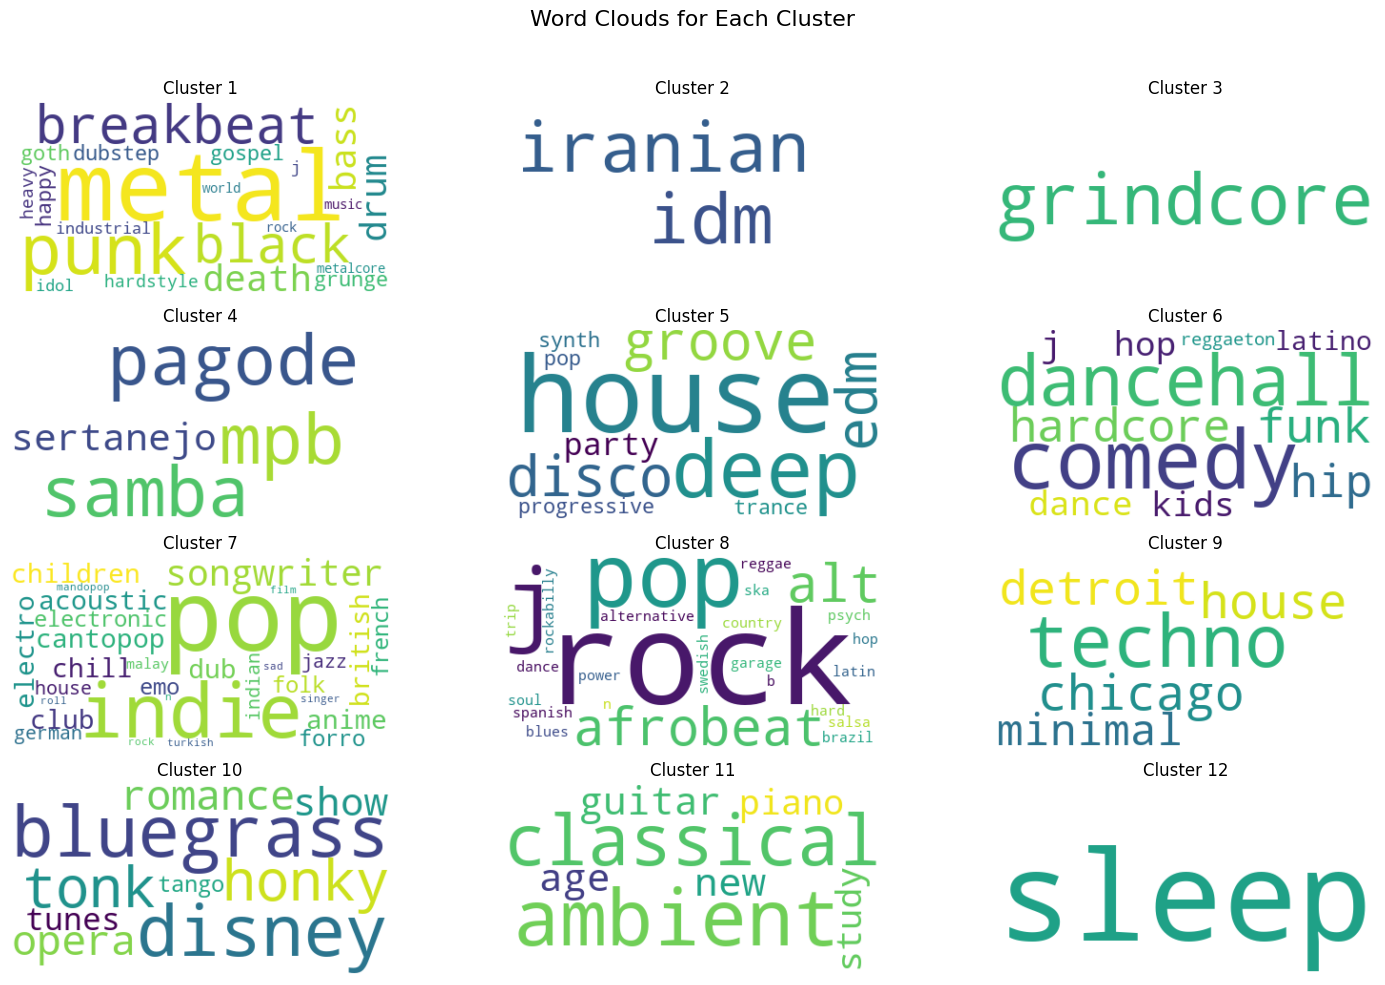

In [253]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the clusters and genres
clusters = {
    1: ['black-metal', 'breakbeat', 'death-metal', 'drum-and-bass', 'dubstep', 'gospel', 'goth', 'grunge', 'happy', 'hardstyle', 'heavy-metal', 'industrial', 'j-idol', 'metal', 'metalcore', 'punk', 'punk-rock', 'world-music'],
    2: ['idm', 'iranian'],
    3: ['grindcore'],
    4: ['mpb', 'pagode', 'samba', 'sertanejo'],
    5: ['deep-house', 'disco', 'edm', 'groove', 'party', 'progressive-house', 'synth-pop', 'trance'],
    6: ['comedy', 'dancehall', 'funk', 'hardcore', 'hip-hop', 'j-dance', 'kids', 'latino', 'reggaeton'],
    7: ['acoustic', 'anime', 'british', 'cantopop', 'children', 'chill', 'club', 'dub', 'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'german', 'house', 'indian', 'indie', 'indie-pop', 'jazz', 'k-pop', 'malay', 'mandopop', 'pop', 'pop-film', 'rock-n-roll', 'sad', 'singer-songwriter', 'songwriter', 'turkish'],
    8: ['afrobeat', 'alt-rock', 'alternative', 'blues', 'brazil', 'country', 'dance', 'garage', 'hard-rock', 'j-pop', 'j-rock', 'latin', 'power-pop', 'psych-rock', 'r-n-b', 'reggae', 'rock', 'rockabilly', 'salsa', 'ska', 'soul', 'spanish', 'swedish', 'trip-hop'],
    9: ['chicago-house', 'detroit-techno', 'minimal-techno', 'techno'],
    10: ['bluegrass', 'disney', 'honky-tonk', 'opera', 'romance', 'show-tunes', 'tango'],
    11: ['ambient', 'classical', 'guitar', 'new-age', 'piano', 'study'],
    12: ['sleep']
}

# Define the number of rows and columns for the subplots
n_rows = 4
n_cols = 3

# Create a figure for the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.suptitle('Word Clouds for Each Cluster', fontsize=16)

# Generate word clouds and place them in the subplots
for i, (cluster, genres) in enumerate(clusters.items()):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(genres))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Cluster {cluster}')
    ax.axis('off')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


As we can visualize above we can see how classes can be unbalanced and also might not be grouped as wished. The reason could be that the features aren't describing well enough the genre patterns ... 